In [376]:
%load_ext autoreload
%autoreload 2

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
#import pymaise 
print("hi")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
hi


In [377]:
from pyMAISE.datasets import load_anomaly
from pyMAISE.preprocessing import train_test_split, scale_data, one_hot_encode, SplitSequence
import pyMAISE as mai

In [378]:
global_settings = mai.init(
    problem_type=mai.ProblemType.CLASSIFICATION,   # Define a regression problem
    cuda_visible_devices="-1" ,                 # Use CPU only/ Delete line when run on GPU
    verbosity = 3
)
#GRU 1st, GRU 2nd, and CNN LSTM for 2nd 

#add hyperp. tuning 

Num GPUs Available:  0


In [379]:
# call handler
input_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL.npy"
output_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL_labels.npy"
#print(mai.__file__)
#False, False, False:       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)  one hot !
#False, True, False:        X.shape = (1077, 4500, 14), Y.shape = (1077, 1)
#False, False, True:        X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#False, True, True:         X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#True, False, True:         X.shape = (4846500, 14), Y.shape = (4846500, 1) !!!!
#True, True, True:          X.shape = (4846500, 14), Y.shape = (4846500, 1)
cond1 = True #stack series
cond2 = False #multiclass
cond3 = True #propogate output
#true f t is the !
#F F F is the !!!
fract = 0.2
#inputs, outputs = load_anomaly([input_path, output_path], cond1, cond2, cond3)
steping = 150
inputs, outputs = load_anomaly(input_path, output_path, cond1, cond2, cond3, fract, steping)

In [380]:
inputs.shape

(10260, 14)

In [381]:
outputs.shape

(10260, 1)

In [382]:
outputs = one_hot_encode(outputs)
outputs

<xarray.DataArray (time steps: 10260, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])
Coordinates:
  * time steps  (time steps) int64 0 1 2 3 4 5 ... 10255 10256 10257 10258 10259
  * features    (features) object 'Class_Fault' 'Class_Run'

In [383]:
data = xr.concat([inputs, outputs], dim="features")
data.shape

(10260, 16)

In [384]:
split_sequence = SplitSequence(
    10, 
    1, 
    0, 
    sequence_inputs=data.coords["features"].values[:-2], 
    sequence_outputs=data.coords["features"].values[-2:],
)
inputs, outputs = split_sequence.split(data)


In [385]:
inputs.shape

(10251, 10, 14)

In [386]:
outputs.shape

(10251, 2)

In [387]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [388]:
xtrain, xtest, ytrain, ytest = train_test_split(inputs, outputs, test_size=0.3)
xtrain, xtest, x_scaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, y_scaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

In [389]:

xtrain.shape

(7175, 10, 14)

In [390]:
ytrain.shape

(7175, 2)

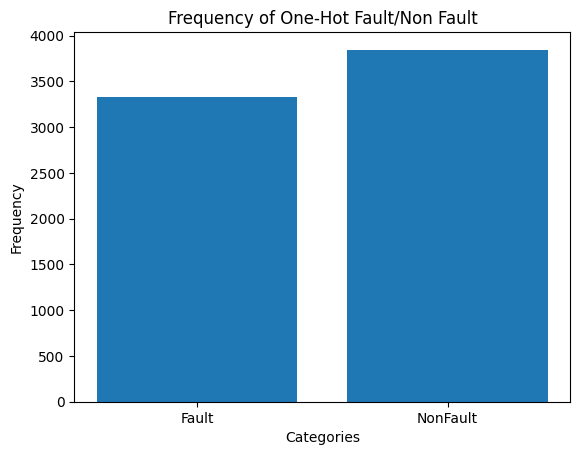

<xarray.DataArray (samples: 7175, features: 2)>
array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])
Coordinates:
  * samples   (samples) int64 6770 9262 5629 5312 457 ... 2492 429 3736 4185
  * features  (features) object 'Class_Fault' 'Class_Run'

In [391]:
ytrain

frequency = np.sum(ytrain, axis=0)

# Categories
categories = ['Fault', 'NonFault']

# Plot
plt.bar(categories, frequency)
plt.title('Frequency of One-Hot Fault/Non Fault')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='y')
plt.show()
ytrain

In [392]:
lstm_structure = {
    "LSTM_input": {
        "units": 50,
        "input_shape": xtrain.shape[1:],
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
        "return_sequences": True,
    },
    "LSTM": {
        "num_layers": mai.Int(0, 3),
        "units": 50,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
        "return_sequences": True,
    },


        
    "GRU": {  # Adding GRU layer
        "num_layers": mai.Int(min_value=0, max_value=3),
        "units": 50,
        "return_sequences": True,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",

    },
    "LSTM_output": {
        "units": 50,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
    },
    "Dense": {
        "num_layers": mai.Int(0, 3),
        "units": 25,
        "activation": "relu",
    },
    "Dense_output": {
        "units": ytrain.shape[-1],
        "activation": "sigmoid",
    },
}

model_settings = {
    "models": ["LSTM", "GRU"],
    "LSTM": {
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": {"learning_rate": mai.Float(1e-5, 0.001)},
        "compile_params": {
            "loss": "binary_crossentropy",
            "metrics": ["accuracy"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([16, 32, 64, 128, 256, 512]),
            "epochs": 5,
            "validation_split": 0.15,
        },
    },
    "GRU": {
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": {"learning_rate": mai.Float(1e-5, 0.001)},
        "compile_params": {
            "loss": "binary_crossentropy",
            "metrics": ["accuracy"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([16, 32, 64, 128, 256, 512]),
            "epochs": 5,
            "validation_split": 0.15,
        },
    },
    
}





tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)


In [393]:
import time
from sklearn.model_selection import TimeSeriesSplit
start = time.time()

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="accuracy_score",
    max_trials=20,
    cv=TimeSeriesSplit(n_splits=2),
)

print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 20 Complete [00h 01m 05s]
accuracy_score: 0.6951066499372648

Best accuracy_score So Far: 0.7189460476787954
Total elapsed time: 00h 09m 12s

Top Configurations

-- LSTM | Training Time: 00:07:51
LSTM_num_layers: 3
GRU_num_layers: 0
Dense_num_layers: 2
Adam_learning_rate: 0.0004917785727465292
batch_size: 64

-- GRU | Training Time: 00:09:11
LSTM_num_layers: 1
GRU_num_layers: 2
Dense_num_layers: 1
Adam_learning_rate: 0.0007971355242701006
batch_size: 16
Hyperparameter tuning took 17.055735754966737 minutes to process.


In [394]:
xtrain

<xarray.DataArray (samples: 7175, time steps: 10, features: 14)>
array([[[0.73540503, 0.62636737, 0.81709206, ..., 0.49366186,
         0.96115924, 0.33561166],
        [0.29919163, 0.63743285, 0.80196098, ..., 0.49460136,
         0.95848842, 0.37165049],
        [0.83798893, 0.64682169, 0.82554778, ..., 0.25902973,
         0.95310135, 0.6807534 ],
        ...,
        [0.82781551, 0.63877411, 0.82643785, ..., 0.51055584,
         0.95676818, 0.63711068],
        [0.81552219, 0.63139717, 0.82643785, ..., 0.50680171,
         0.95527428, 0.59728932],
        [0.82315262, 0.6347503 , 0.82821807, ..., 0.50774028,
         0.95527428, 0.53281553]],

       [[0.8189947 , 0.63248573, 0.82215817, ..., 0.50961732,
         0.959439  , 0.56957243],
        [0.81857082, 0.63282103, 0.82260322, ..., 0.51055584,
         0.959439  , 0.57336497],
        [0.81941863, 0.63147979, 0.82304824, ..., 0.50961732,
         0.96002752, 0.56957196],
...
        [0.8164513 , 0.62544417, 0.84129449, ..., 0.47019911,
         0.91874228, 0.49941748],
        [0.81687519, 0.63416229, 0.80079657, ..., 0.49741646,
         0.91865171, 0.6207767 ],
        [0.81433175, 0.63013845, 0.81637278, ..., 0.50304758,
         0.91806325, 0.64543689]],

       [[0.20765619, 0.6350856 , 0.81976235, ..., 0.51853324,
         0.93503909, 0.39627184],
        [0.68707809, 0.62368484, 0.02628484, ..., 0.50680171,
         0.93137227, 0.37926214],
        [0.81085924, 0.14184479, 0.45573692, ..., 0.51947181,
         0.93005951, 0.360233  ],
        ...,
        [0.85197794, 0.6471568 , 0.82866284, ..., 0.32144228,
         0.92571365, 0.74902524],
        [0.82188064, 0.6357562 , 0.82243254, ..., 0.47958483,
         0.92032669, 0.68450486],
        [0.80916361, 0.62435561, 0.82154246, ..., 0.49366186,
         0.92068881, 0.36784466]]])
Coordinates:
  * samples     (samples) int64 6770 9262 5629 5312 457 ... 2492 429 3736 4185
  * time steps  (time steps) int64 0 1 2 3 4 5 6 7 8 9
  * features    (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [395]:
ytrain.shape

(7175, 2)

In [396]:
xtrain.shape

(7175, 10, 14)

In [397]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 500}},
    },
  #  y_scaler=y_scaler,
)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 4ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 4ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 2ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 3ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 4ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 4ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 2ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 4ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 1ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [================

In [398]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
8,GRU,"{'LSTM_num_layers': 0, 'GRU_num_layers': 0, 'D...",0.765714,0.765714,0.765714,0.765714,0.771782,0.771782,0.771782,0.771782
5,GRU,"{'LSTM_num_layers': 1, 'GRU_num_layers': 2, 'D...",0.746341,0.746341,0.746341,0.746341,0.770156,0.770156,0.770156,0.770156
9,GRU,"{'LSTM_num_layers': 0, 'GRU_num_layers': 3, 'D...",0.755540,0.755540,0.755540,0.755540,0.761704,0.761704,0.761704,0.761704
1,LSTM,"{'LSTM_num_layers': 1, 'GRU_num_layers': 1, 'D...",0.746202,0.746202,0.746202,0.746202,0.760403,0.760403,0.760403,0.760403
6,GRU,"{'LSTM_num_layers': 1, 'GRU_num_layers': 1, 'D...",0.744948,0.744948,0.744948,0.744948,0.759753,0.759753,0.759753,0.759753
4,LSTM,"{'LSTM_num_layers': 1, 'GRU_num_layers': 2, 'D...",0.740070,0.740070,0.740070,0.740070,0.757152,0.757152,0.757152,0.757152
7,GRU,"{'LSTM_num_layers': 3, 'GRU_num_layers': 0, 'D...",0.744111,0.744111,0.744111,0.744111,0.755202,0.755202,0.755202,0.755202
0,LSTM,"{'LSTM_num_layers': 3, 'GRU_num_layers': 0, 'D...",0.740627,0.740627,0.740627,0.740627,0.749675,0.749675,0.749675,0.749675
2,LSTM,"{'LSTM_num_layers': 0, 'GRU_num_layers': 1, 'D...",0.724599,0.724599,0.724599,0.724599,0.736996,0.736996,0.736996,0.736996
3,LSTM,"{'LSTM_num_layers': 2, 'GRU_num_layers': 0, 'D...",0.700348,0.700348,0.700348,0.700348,0.702861,0.702861,0.702861,0.702861


In [399]:
for model in [ "LSTM"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: LSTM
LSTM_num_layers: 1
GRU_num_layers: 1
Dense_num_layers: 2
Adam_learning_rate: 0.0007100077201907306
batch_size: 64



In [400]:
idx = postprocessor._get_idx()
idx

8

In [401]:
#postprocessor._models()
yhat_test = postprocessor._models["Test Yhat"][idx]

In [402]:
postprocessor.get_model()

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [403]:
 yhat_test

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

In [404]:
#postprocessor.confusion_matrix(model_type = "LSTM")
yhat_train = postprocessor._models["Train Yhat"][idx]
yhat_test = postprocessor._models["Test Yhat"][idx]


In [405]:
ytrain = postprocessor._ytrain.values
ytest = postprocessor._ytest.values

In [406]:
#ax = plt.gca()

In [407]:
from sklearn.preprocessing import StandardScaler

ytrain = y_scaler.inverse_transform(
                ytrain.reshape(-1, ytrain.shape[-1])
            )
ytest = y_scaler.inverse_transform(ytest.reshape(-1, ytest.shape[-1]))

In [408]:
xtrain.shape

(7175, 10, 14)

In [409]:
ytrain = np.round(ytrain).astype(int)
ytrain.shape

(7175, 2)

In [410]:
yhat_train.shape

(7175, 2)

In [411]:
yhat_train_single = np.argmax(yhat_train, axis=1)

In [412]:
ytrain_single = np.argmax(ytrain, axis=1)

In [413]:
yhat_train_single.shape

(7175,)

In [414]:
ytrain_single.shape

(7175,)

In [415]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(ytrain_single , yhat_train_single)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)


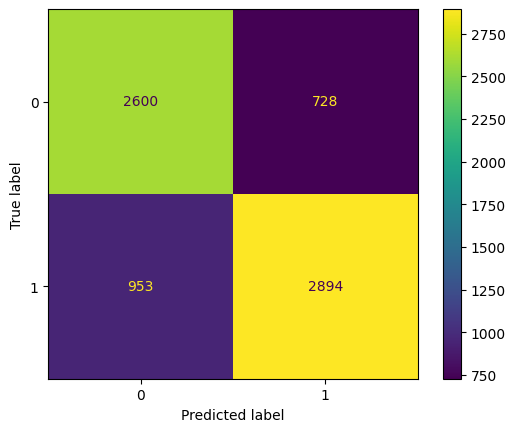

In [416]:
train_disp.plot()

In [417]:
ytest = np.round(ytest).astype(int)
ytest.shape

(3076, 2)

In [418]:
yhat_test.shape

(3076, 2)

In [419]:
yhat_test_single = np.argmax(yhat_test, axis=1)

In [420]:
ytest_single = np.argmax(ytest, axis=1)

In [421]:
yhat_test_single.shape

(3076,)

In [422]:
ytest_single.shape

(3076,)

In [423]:
test_cm = confusion_matrix(ytest_single, yhat_test_single)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)



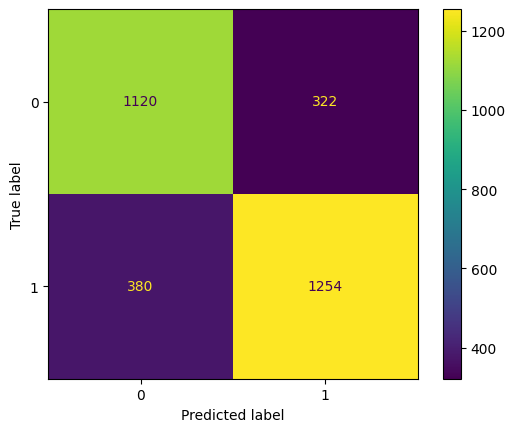

In [424]:
test_disp.plot()

In [425]:
##use pyMAISE one

In [426]:
xtrain.shape

(7175, 10, 14)